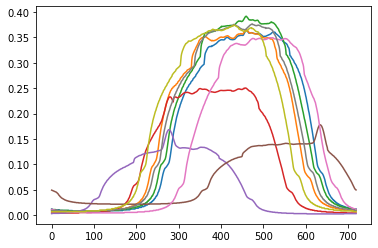

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import os
observations = []
avgs = []
for file in os.listdir():
    if 'fits' in file:
        obs = np.flip(fits.open(file)[0].data, 0)
        observations.append(obs)
        avgs.append(np.mean(obs, 0))
        plt.plot(np.mean(obs, 0))
plt.show()

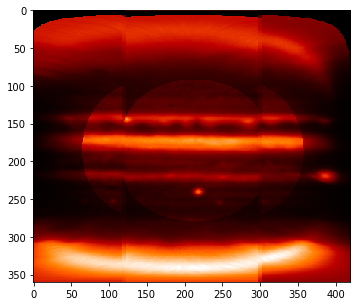

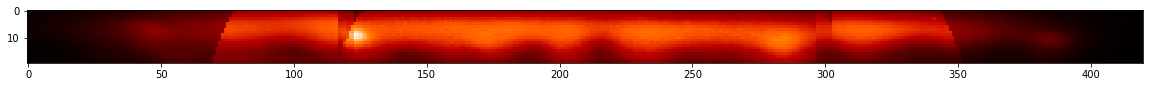

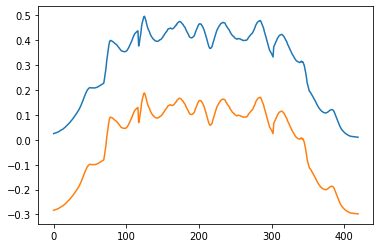

Fourier
Non-detrended
[ 0.         17.14285714 27.42857143 15.42857143  6.85714286 18.85714286
 46.28571429  8.57142857 20.57142857 58.28571429]
Detrended
[17.14285714 27.42857143 15.42857143  6.85714286 18.85714286 46.28571429
  8.57142857 20.57142857 58.28571429 39.42857143]
Lomb-Scargle periodogram
Non-detrended
[0.17183771 0.51551313 0.85918854 1.20286396 1.54653938 1.8902148
 2.23389021 3.9522673  4.29594272 3.60859189]
Detrended
[0.17183771 0.51551313 0.85918854 1.20286396 1.54653938 1.8902148
 2.23389021 3.9522673  4.29594272 3.60859189]


In [266]:
nbins = 12
cutoff = 0.15
gradient = 6

binstarts = [int(x) for x in np.linspace(0, 720, nbins+1)]
keepbins = []
lmap = np.full((360, 720), 0.)
cmaps = []

#choose the maps with the highest average brightness over the bin
for bin in range(len(binstarts)-1):
    bestObs = None
    maxBrightness = 0
    for obs in observations:
        avgBrightness = np.mean(obs[:, binstarts[bin]:binstarts[bin+1]])
        if avgBrightness > maxBrightness:
            bestObs = obs
            maxBrightness = avgBrightness
    if maxBrightness < cutoff:
        lmap[:, binstarts[bin]:binstarts[bin+1]] = np.full((len(lmap), binstarts[bin+1]-binstarts[bin]), -1)
    else:
        lmap[:, binstarts[bin]:binstarts[bin+1]] = bestObs[:, binstarts[bin]:binstarts[bin+1]]
        keepbins.append(bin)
    cmaps.append(bestObs)

#stitch together at the bin edges
for idx in range(len(keepbins)-1):
    bin = keepbins[idx]
    nextBin = keepbins[idx+1]
    if bin + 1 == nextBin:
        stitchStart = binstarts[nextBin]-gradient//2
        stitchEnd = binstarts[nextBin]+gradient//2
        lmap[:, stitchStart:stitchEnd] = (cmaps[bin][:, stitchStart:stitchEnd] + cmaps[nextBin][:, stitchStart:stitchEnd]) / 2.0
lmap = lmap[:, np.argwhere(np.mean(lmap, 0)!=-1).flatten()]

plt.figure(figsize=(10, 5))
plt.imshow(lmap, cmap='gist_heat')
nebStart = 135
nebEnd = 155
neb = lmap[nebStart:nebEnd, :]
plt.figure(figsize=(20, 15))
plt.imshow(neb, cmap='gist_heat')
plt.show()

plt.clf()
from scipy.signal import detrend
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html
nebAvg = np.mean(neb, 0)
lon = np.arange(len(nebAvg))
plt.plot(lon, nebAvg)
#detrend with median filter, bins=separate cmap regions
avg_detrended = detrend(nebAvg, type='constant', bp=[int(i) for i in np.linspace(0, len(lmap), len(keepbins))])
plt.plot(lon, avg_detrended)
plt.show()

from scipy.fft import fft
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fft.html
print('Fourier')
fourier = fft(nebAvg)
xf = np.arange(len(nebAvg)//2)
print('Non-detrended')
print(720 / len(nebAvg) * np.flip(np.argsort(fourier[0:len(nebAvg)//2]))[:10])
fourier_detrended = fft(avg_detrended)
print('Detrended')
print(720 / len(nebAvg) * np.flip(np.argsort(fourier_detrended[0:len(nebAvg)//2]))[:10])

from astropy.timeseries import LombScargle
print("Lomb-Scargle periodogram")
lon_normed = (lon-np.min(lon))/len(lon)
print('Non-detrended')
frequency, power = LombScargle(lon_normed,nebAvg).autopower()
print(720 / len(lon_normed) * frequency[np.flip(np.argsort(power[0:len(frequency)//20]))][:10])
print('Detrended')
frequency, power_detrended = LombScargle(lon_normed,avg_detrended).autopower()
print(720 / len(lon_normed) * frequency[np.flip(np.argsort(power_detrended[0:len(frequency)//20]))][:10])

In [267]:
[int(i) for i in np.linspace(0, len(lmap), len(keepbins))]

[0, 60, 120, 180, 240, 300, 360]

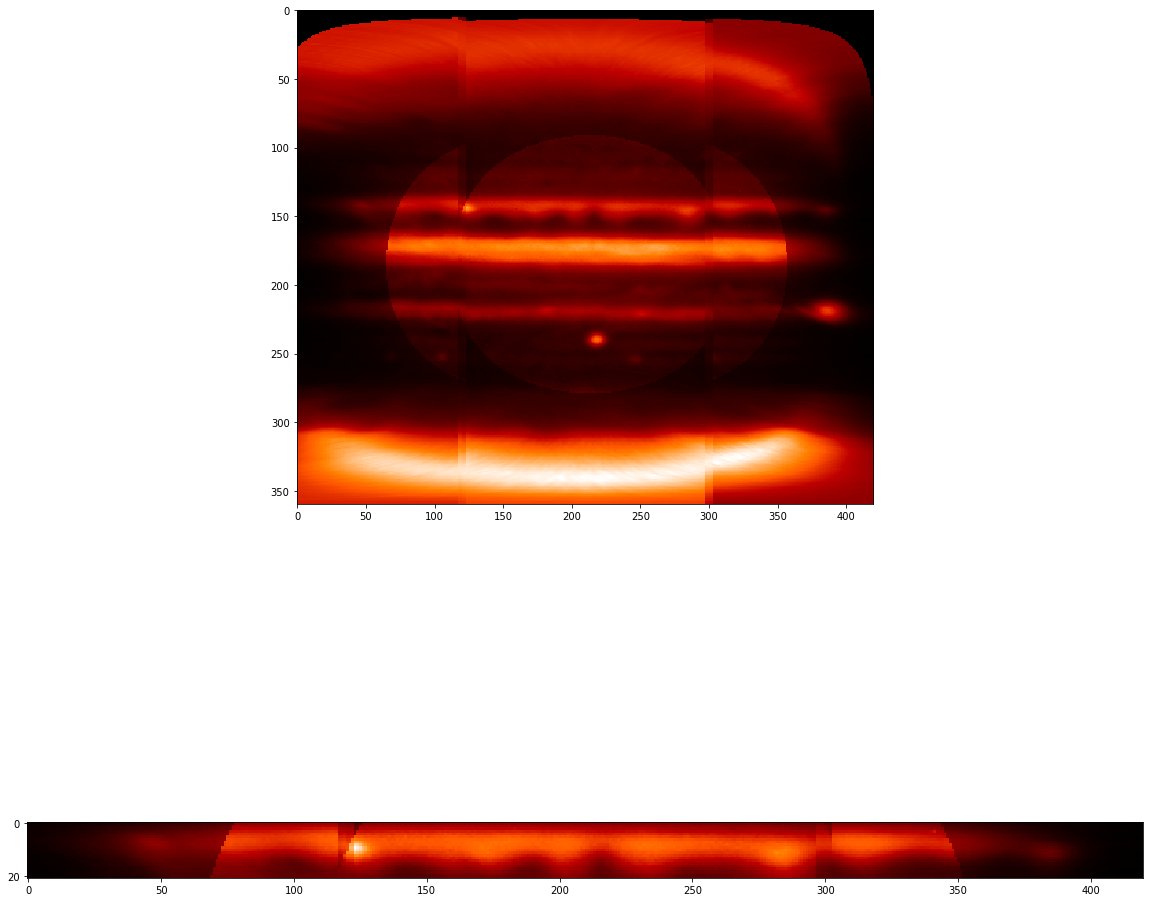

In [259]:
nebStart = 135
nebEnd = 156
neb = lmap[nebStart:nebEnd, :]

fig, axes = plt.subplots(2,1, figsize=(20,20))
axes[0].imshow(lmap, cmap='gist_heat')
axes[1].imshow(neb, cmap='gist_heat')
# axes[2].plot
# plt.savefig('test.png')